# Machine Learning with PyTorch

### How does this lab work ?

The lab uses MNIST datasets. The dataset has over 60.000 images of hand written digits. The data will be partitioned between training the AI model and testing the AI model after training.

The main steps in  this project include:

1. Download the MNIST dataset and create a DataLoader for the dataset.
2. Define an AI model to recognize a hand written the MNIST dataset.
3. Train the defined AI model using training data from the MNIST dataset.
4. Test the trained AI model using testing data from the MNIST dataset.
5. Evaluate

In [27]:
import torch
print(torch.__version__)
print(torch.nn)

2.9.1+cu128
<module 'torch.nn' from '/home/machine01/.cache/pypoetry/virtualenvs/cognitiveclass-computer-vision-hands-on-wi-KamljRSP-py3.11/lib/python3.11/site-packages/torch/nn/__init__.py'>


In [28]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


# Download Dataset adn Create Data Loader

In [29]:
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

valid_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

BATCH_SIZE: int = 64

train_dataloader: DataLoader = DataLoader(training_data, batch_size=BATCH_SIZE)
valid_dataloader: DataLoader = DataLoader(
    valid_data, batch_size=BATCH_SIZE
)

print(
    "Training data Size "
    f"{len(train_dataloader) * BATCH_SIZE}"
)
print(
    "Validation data Size "
    f"{len(valid_dataloader) * BATCH_SIZE}"
)

for X, y in valid_dataloader:
    print(
        f"Shape of X [N, C, H, W]: {X.shape}\n"
        f"Shape of y {y.shape} {y.dtype}"
    )
    break



Training data Size 60032
Validation data Size 10048
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y torch.Size([64]) torch.int64


# Define Model


We first determine the best device for perfoming training with cpu as the default device.

We the define the AI model as a Neural Network with 3 layers: an input layer, a hiddern layer,  and an output layer. Between the layers, we use a ReLU activation function.

Since the input images are 1X28x28 tensors, we need to flatten the input tensors into a 784 element tensor using the Flatten module before passing the input into our neural network.

In [30]:
device  =  torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(
    f"Using {device} device"
)



Using cpu device


In [31]:
# Define a model

class NeuralNetwork(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_classes
    ):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(
                input_size, hidden_size
            ),
            nn.ReLU(),
            nn.Linear(
                hidden_size, hidden_size
            ),
            nn.ReLU(),
            nn.Linear(
                hidden_size, num_classes
            ),

        )
    def forward(
        self,
        image_tensor
    ):
        image_tensor = self.flatten(image_tensor)
        logits = self.linear_relu_stack(image_tensor)
        return logits


INPUT_SIZE = 28*28
HIDDEN_SIZE = 512
NUM_CLASSES = 10

model = NeuralNetwork(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_classes=NUM_CLASSES
)

print('(-)'*30)
print(
    model
)
print('(-)'*30)


(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)(-)


## Training Loop

We implement a training function to use with the train_dataloader to train our model. Each iteration over the dataloader returns a batch_size image data tensor along with the expected output. After moving the tensors to the device, we call the forward pass of our model, computer the prediction error using the expected output and then call the backwards pass to compute the gradients and apply them to the model parameters.

In [32]:
def train(
    dataloader, model, loss_fn, optimizer
):
    size = len(dataloader.dataset)
    model.train()
    for batch_num, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass to compute prediction
        pred = model(X)
        # Compute prediction error using loss function
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad() # Zero any previous gradient calculations
        loss.backward() #Calculate gradient
        optimizer.step() # Update model parameters

        if batch_num > 0 and batch_num % 100 == 0:
            loss, current = loss.item(), batch_num * len(X)
            print(
                f'Loss: {loss:>7f} [{current:>5d}/{size:>5d}]'
            )


# Test Loop

The test methods evaluates the model's predictive performance using the test_dataloader. During testing, we don't require gradient computation, so we set the model in evaluate mode.

In [33]:
# Our Test function
def valid(
    dataloader,
    model,
    loss_fn
):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Results: \n Accuracy: {(100*correct):>0.1f}%, Avg Loss: {test_loss:>8f} \n"
    )


# Train the model

Now that we have defined methods to train our model and test the trained model's predictive behavior, lets train the model for 5 epochs over the dataset.

In [34]:
# Let's run training

LEARNING_RATE = 1e-3 # 0.001
LOSSS_FN = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


epochs = 5
for t in range(epochs):
    print('-'*30)
    print(f"Epoch {t+1}")
    train(train_dataloader, model, loss_fn=LOSSS_FN, optimizer=OPTIMIZER)
    valid(valid_dataloader, model, loss_fn=LOSSS_FN)

print("Done!")

------------------------------
Epoch 1
Loss: 0.288435 [ 6400/60000]
Loss: 0.188156 [12800/60000]
Loss: 0.242913 [19200/60000]
Loss: 0.133550 [25600/60000]
Loss: 0.315731 [32000/60000]
Loss: 0.135211 [38400/60000]
Loss: 0.209901 [44800/60000]
Loss: 0.348768 [51200/60000]
Loss: 0.145479 [57600/60000]
Results: 
 Accuracy: 95.9%, Avg Loss: 0.130512 

------------------------------
Epoch 2
Loss: 0.094937 [ 6400/60000]
Loss: 0.095883 [12800/60000]
Loss: 0.072174 [19200/60000]
Loss: 0.040271 [25600/60000]
Loss: 0.106885 [32000/60000]
Loss: 0.049354 [38400/60000]
Loss: 0.111289 [44800/60000]
Loss: 0.169942 [51200/60000]
Loss: 0.066484 [57600/60000]
Results: 
 Accuracy: 97.1%, Avg Loss: 0.093582 

------------------------------
Epoch 3
Loss: 0.059573 [ 6400/60000]
Loss: 0.049415 [12800/60000]
Loss: 0.048211 [19200/60000]
Loss: 0.034627 [25600/60000]
Loss: 0.042471 [32000/60000]
Loss: 0.032148 [38400/60000]
Loss: 0.050934 [44800/60000]
Loss: 0.069535 [51200/60000]
Loss: 0.034441 [57600/60000]
Re

# Save the model and make predicitions

Once we have a trained model, we can save the model parameters for future use in inferences. Here we save the state_dict of the model which contais the trained parameters. We then create a new instance of the model and load the previously saved parameters into the new instance of the model. Finally we can inference using the new instance of the model.

In [35]:
# Save our model parameters

torch.save(
    model.state_dict(), "ml_with_pytorch_model.pth"
)
print(
    "Saved Pytorch model state to ml_wti_pytorch_model.pth"
)

# Load the saved model paameters into a new instance of the model

model = NeuralNetwork(
    INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES
).to(device)
model.load_state_dict(torch.load("ml_with_pytorch_model.pth"))

# Inference Using the new model isntance
model.eval()

for i in range(10):
    x, y  = valid_data[i][0], valid_data[i][1]

    x = x.to(device)
    pred = model(x)
    predicted, actual = pred[0].argmax(0).item(), y
    print(
        f"Predicted: {predicted}, Actual: {actual}"
    )

Saved Pytorch model state to ml_wti_pytorch_model.pth
Predicted: 7, Actual: 7
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 4, Actual: 4
Predicted: 1, Actual: 1
Predicted: 4, Actual: 4
Predicted: 9, Actual: 9
Predicted: 5, Actual: 5
Predicted: 9, Actual: 9


In [36]:
len(valid_data)

10000

In [48]:
full_preds, full_y = [], []

for i in range(len(valid_data)):
    x, y  = valid_data[i][0], valid_data[i][1]

    x = x.to(device)
    pred = model(x)
    predicted, actual = pred[0].argmax(0).item(), y
    full_preds.append(predicted)
    full_y.append(y)

In [49]:
min(full_preds), max(full_preds), min(full_y), max(full_y)

(0, 9, 0, 9)

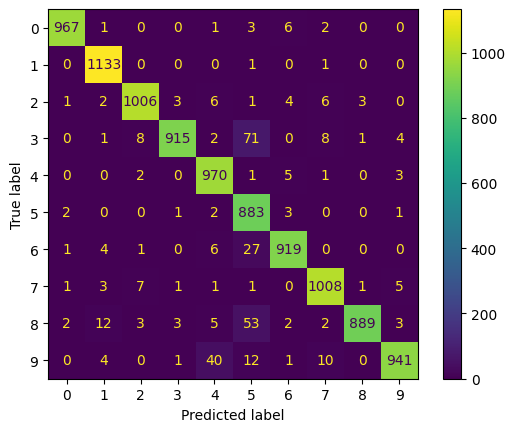

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(
    full_y,
    full_preds,
    labels=list(range(10)))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(range(10)
    )
)
disp.plot()
plt.show()